In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/kyuyeon/practice/

/content/drive/MyDrive/kyuyeon/practice




---



## CelebADataset

In [3]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla P100-PCIE-16GB


device(type='cuda')



---



In [5]:
# 가짜 데이터 생성
def generate_random(size):
  random_data = torch.rand(size) # 0-1사이 랜덤값
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size) # 평균 0, 표준편차 1인 가우시안 정규분포를 따르는 랜덤값
  return random_data

In [6]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

In [7]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[ starty:starty + new_height, startx:startx + new_width, :]



---



In [8]:
class CelebADataset(Dataset):
  
  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index):
    if (index >= len(self.dataset)):
      raise IndexError()
    img = np.array(self.dataset[str(index)+'.jpg'])
    img = crop_centre(img, 128, 128)
    return torch.cuda.FloatTensor(img).permute(2, 0, 1).view(1, 3, 128, 128)  # permute 행렬 순서 변경
  
  def plot_image(self, index):
    plt.imshow(np.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
    pass
  
  pass


In [9]:
celeba_dataset = CelebADataset('/content/drive/MyDrive/kyuyeon/practice/celeba_aligned_small.h5py')

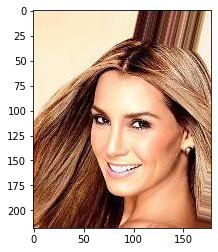

In [10]:
celeba_dataset.plot_image(0)



---



## Discriminator

In [11]:
# 판별자 클래스
class Discriminator(nn.Module):

  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        # (1, 3, 128, 128)
        nn.Conv2d(3, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 3, kernel_size=8, stride=2),
        nn.GELU(),

        View(3*10*10),
        nn.Linear(3*10*10, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.BCELoss()

    # SGD 옵티마이저 설정
    # self.parameters() 모든 학습 파라미터
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    self.optimizer.param_groups[0]['capturable'] = True

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass
  
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)
  

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()   # 계산 그래프의 기울기 0으로 초기화
    loss.backward()   # 신경망의 기울기
    self.optimizer.step()   # 위 기울기는 이 코드를 통해서 신경망의 학습 파라미터를 갱신하는데에 사용됨

    pass
  
  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

In [12]:
# 판별기 테스트
%time

D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
  # 실제 데이터
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random((1, 3, 128,128)), torch.cuda.FloatTensor([0.0]))
  pass

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
counter =  10000
counter =  20000
counter =  30000
counter =  40000


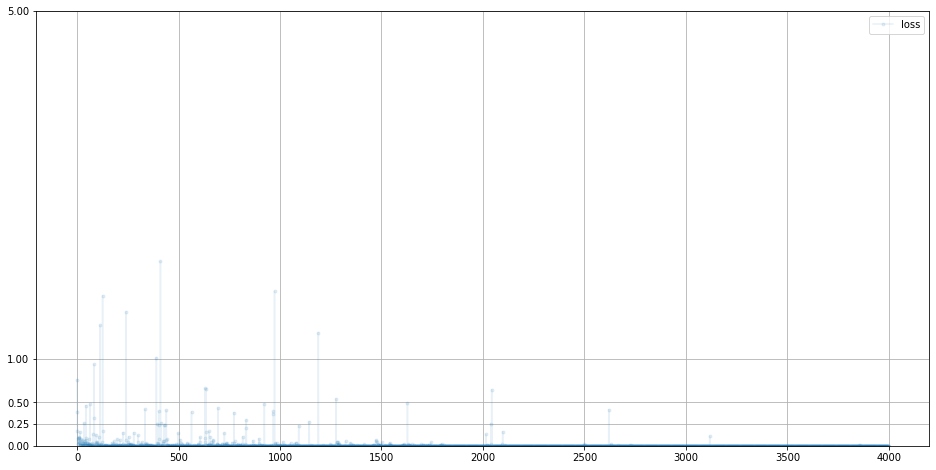

In [13]:
D.plot_progress()

In [14]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random((1, 3, 128,128))).item())
  pass

1.0
1.0
1.0
1.0
4.146170518026793e-09
5.909387823521683e-07
9.552635447107605e-07
1.4477443244231836e-07




---



## Generator

In [15]:
# 생성자 클래스
class Generator(nn.Module):

  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(100, 3*11*11),
        nn.GELU(),

        # 4차원으로 형태 변환
        View((1, 3, 11, 11)),

        nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm2d(3),
        nn.Sigmoid(),
    )

    # SGD 옵티마이저 설정
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    self.optimizer.param_groups[0]['capturable'] = True

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass
  
  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)
  

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    # 생성자 모델의 예측값
    g_output = self.forward(inputs)

    # 판별기로 전달
    # 생성자 모델의 예측값을 판별자 모델의 인풋으로 넣어 판별자 모델의 예측값 도출
    d_output = D.forward(g_output)

    # 오차 계산
    # 판별자 모델의 예측값과 라벨에 대한 손실값 도출
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass
  
  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

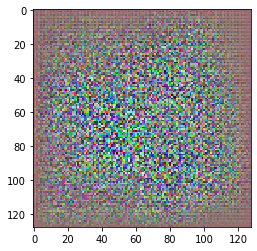

In [16]:
# check the generator output is of the right type and shape

G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')



---



## Training GAN

In [17]:
%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 12

for epoch in range(epochs):
  print("epoch = ", epoch + 1)

  # 판별기, 생성기 훈련
  for image_data_tensor in celeba_dataset:
    # 1단계: 참에 대해 판별기 훈련
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # 2단계: 거짓에 대해 판별기 훈련
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    # 3단계: 생성기 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
  
  pass

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
epoch =  1
counter =  10000
counter =  20000
counter =  10000
counter =  30000
counter =  40000
counter =  20000
epoch =  2
counter =  50000
counter =  60000
counter =  30000
counter =  70000
counter =  80000
counter =  40000
epoch =  3
counter =  90000
counter =  100000
counter =  50000
counter =  110000
counter =  120000
counter =  60000
epoch =  4
counter =  130000
counter =  140000
counter =  70000
counter =  150000
counter =  160000
counter =  80000
epoch =  5
counter =  170000
counter =  180000
counter =  90000
counter =  190000
counter =  200000
counter =  100000
epoch =  6
counter =  210000
counter =  220000
counter =  110000
counter =  230000
counter =  240000
counter =  120000
epoch =  7
counter =  250000
counter =  260000
counter =  130000
counter =  270000
counter =  280000
counter =  140000
epoch =  8
counter =  290000
counter =  300000
counter =  150000
counter =  310000
counter =  320000
counter =  160000
ep

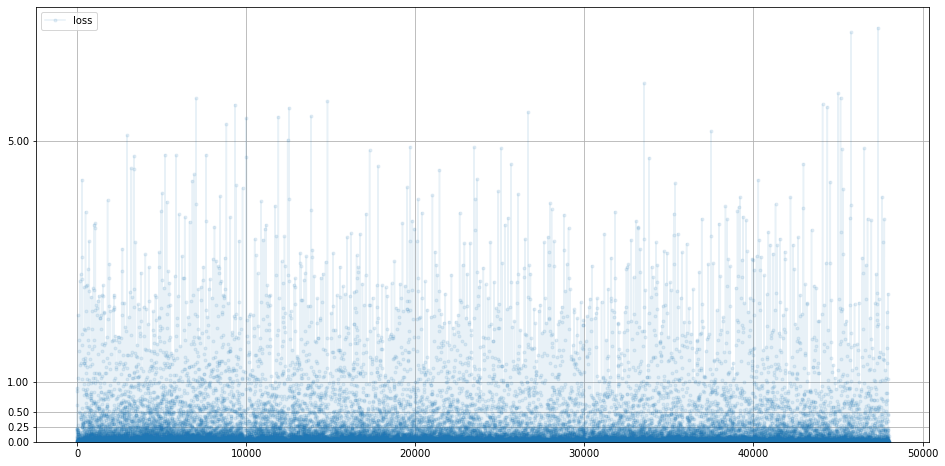

In [18]:
D.plot_progress()

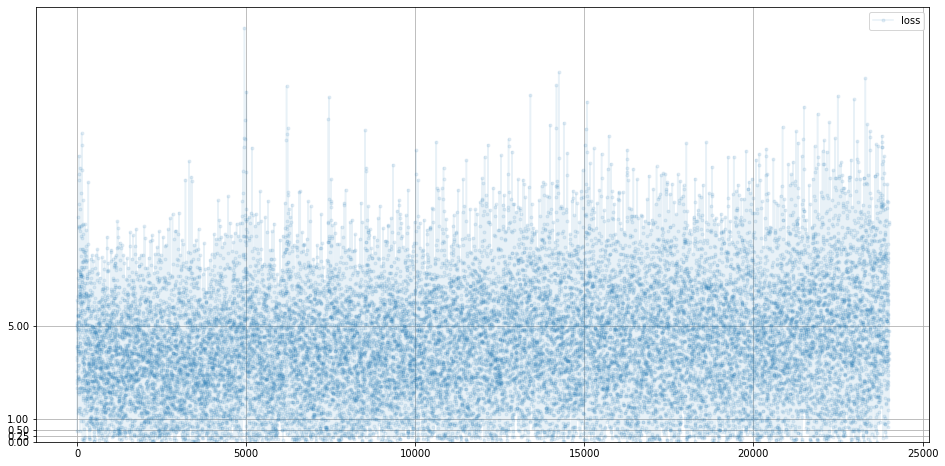

In [19]:
G.plot_progress()

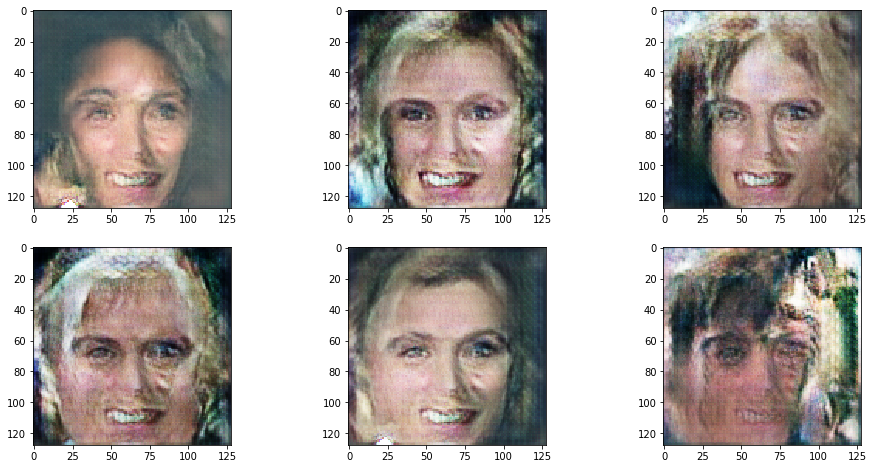

In [20]:
# images test
f, axarr = plt.subplots(2, 3, figsize=(16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass